In [1]:
# Cell 1: Imports

import os
import numpy as np
import pandas as pd

from skimage.transform import resize
from skimage.io import imread

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

sns.set()
RANDOM_STATE = 42


In [2]:
target = []
images = []   # In matrix format
flat_data = []  # In vector format

datadir = '../Data/AppleData'
categories = ['Apple___Apple_scab',
              'Apple___Black_rot',
              'Apple___Cedar_apple_rust',
              'Apple___healthy',
              'Background_without_leaves']

for category in categories:
  path= datadir + '/' + category
  for img in os.listdir(path):
    img_matrix=imread(os.path.join(path,img))
    img_resized=resize(img_matrix,(150,150,3))
    flat_data.append(img_resized.flatten())
    images.append(img_resized)
    target.append(category)

In [3]:
import pandas as pd
df=pd.DataFrame(flat_data)
df['Target']=target

In [5]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 142.4 MB/s  0:00:030:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 306.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 289.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 310.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 124.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 449.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 11/22 [markdown]  WARNING: The script markdown_py is installed in '/home/ahw8xz/.local/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 17/22 [tensorboard]  WARNING: The script tensorboard is installed in '/home/ahw8xz/.local/bin' which is not on PATH.
  Consider adding t

In [6]:
# Cell 4: Imports for Neural Network model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Ensure reproducibility (use same RANDOM_STATE if you already defined one)
try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


2025-12-03 20:04:10.752735: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 20:04:10.873763: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 20:04:12.820891: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
# Cell 5: Prepare features (X) and labels (y) for the NN
# Assumes your dataframe is called `df` and the target column is named "Target"

# 1. Separate features and target
X = df.drop(columns=["Target"]).astype("float32").values
y = df["Target"].values

print("Feature matrix shape:", X.shape)
print("First 5 labels:", y[:5])

# 2. Encode labels to integers, then one-hot for Keras
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

y_onehot = tf.keras.utils.to_categorical(y_encoded, num_classes=num_classes)

print("Classes:", label_encoder.classes_)
print("Encoded labels shape (one-hot):", y_onehot.shape)


Feature matrix shape: (5788, 67500)
First 5 labels: ['Apple___Apple_scab' 'Apple___Apple_scab' 'Apple___Apple_scab'
 'Apple___Apple_scab' 'Apple___Apple_scab']
Classes: ['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Background_without_leaves']
Encoded labels shape (one-hot): (5788, 5)


In [8]:
# Cell 6: Train/validation/test split and feature scaling

# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y_onehot,
    test_size=0.2,
    stratify=y_onehot,
    random_state=RANDOM_STATE
)

# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.2,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

# Standardize features (important for NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]
print("Input dimension for NN:", input_dim)


X_train: (3704, 67500)
X_val: (926, 67500)
X_test: (1158, 67500)
Input dimension for NN: 67500


In [9]:
# Cell 7: Define the neural network model
# This is a simple feed-forward NN for tabular features

def build_nn_model(input_dim, num_classes):
    model = Sequential()

    # First hidden layer
    model.add(Dense(128, activation="relu", input_shape=(input_dim,)))
    model.add(Dropout(0.3))

    # Second hidden layer
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))

    # Output layer (softmax for multi-class classification)
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_nn_model(input_dim=input_dim, num_classes=num_classes)
model.summary()


/home/ahw8xz/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-03 20:04:31.397601: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,648,709 (32.99 MB)

 Trainable params: 8,648,709 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Cell 8: Train the NN with early stopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,           # stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5826 - loss: 14.9585 - val_accuracy: 0.7851 - val_loss: 3.6031
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6593 - loss: 6.5315 - val_accuracy: 0.7970 - val_loss: 1.3315
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6809 - loss: 3.0851 - val_accuracy: 0.7754 - val_loss: 0.9455
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6909 - loss: 1.9129 - val_accuracy: 0.7559 - val_loss: 0.8047
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6992 - loss: 1.3803 - val_accuracy: 0.7462 - val_loss: 0.8520
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7157 - loss: 1.0371 - val_accuracy: 0.7743 - val_loss: 0.6430
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7416 - loss: 0.8842 - val_accuracy: 0.7991 - val_loss: 0.6249
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7559 - loss: 0.8656 - val_acc

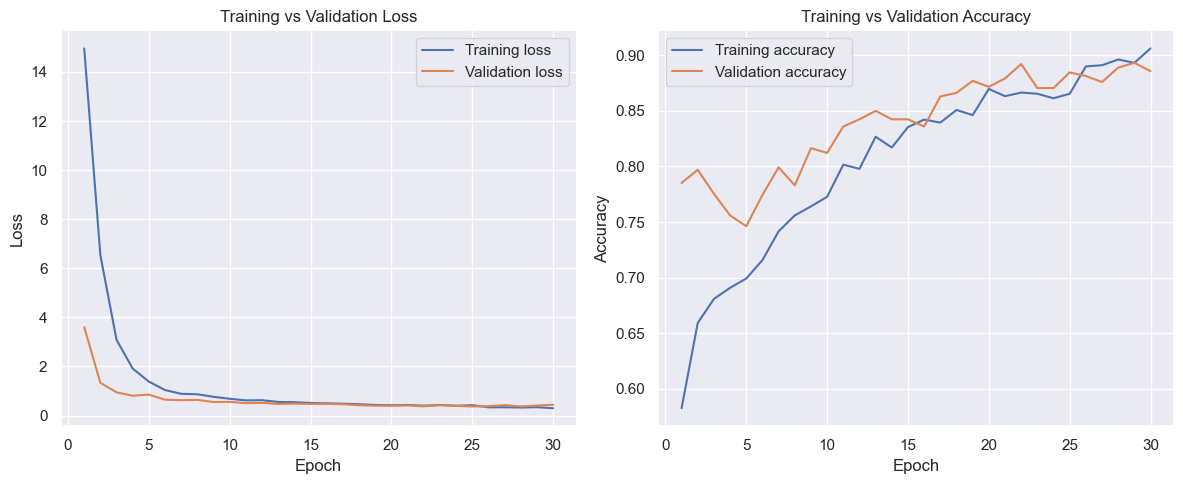

In [11]:
# Cell 9: Plot training and validation loss/accuracy

history_dict = history.history

epochs = range(1, len(history_dict["loss"]) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict["loss"], label="Training loss")
plt.plot(epochs, history_dict["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict["accuracy"], label="Training accuracy")
plt.plot(epochs, history_dict["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
# Cell 10: Evaluate model on test data

test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Predicted class indices
y_test_pred_probs = model.predict(X_test_scaled)
y_test_pred_labels = np.argmax(y_test_pred_probs, axis=1)

# True class indices
y_test_true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(
    y_test_true_labels,
    y_test_pred_labels,
    target_names=label_encoder.classes_
))


Test Loss: 0.3185
Test Accuracy: 0.9050
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Classification Report:

                           precision    recall  f1-score   support

       Apple___Apple_scab       0.96      0.76      0.85       200
        Apple___Black_rot       0.91      0.85      0.88       200
 Apple___Cedar_apple_rust       0.90      0.96      0.93       200
          Apple___healthy       0.86      0.96      0.91       329
Background_without_leaves       0.95      0.95      0.95       229

                 accuracy                           0.91      1158
                macro avg       0.91      0.90      0.90      1158
             weighted avg       0.91      0.91      0.90      1158



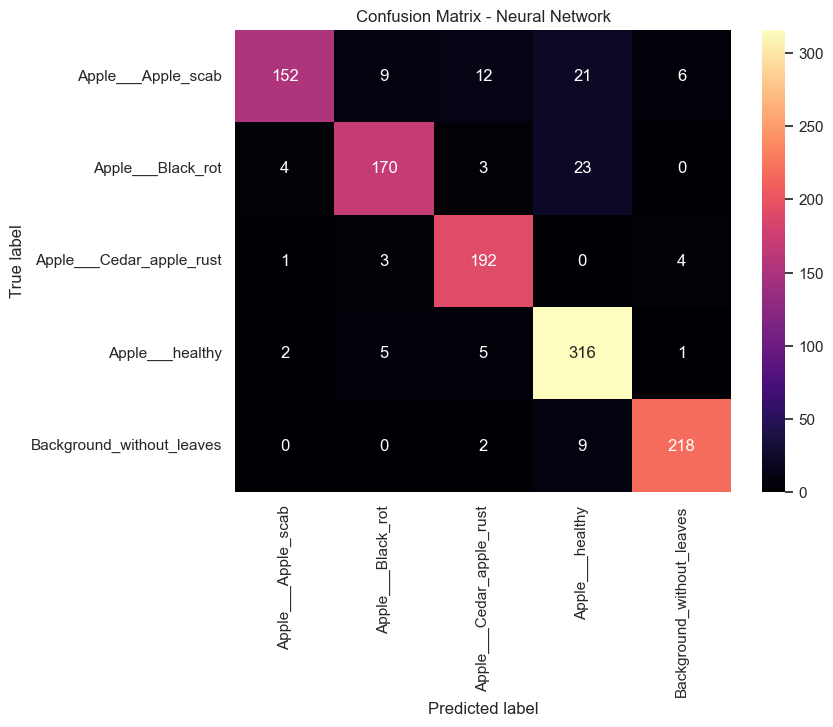

In [13]:
# Cell 11: Confusion matrix for NN model

cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="magma",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix - Neural Network")
plt.show()
